<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/06_CMAB_movielens_neural_egreedy_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contextual Multi-Armed Bandits with neural network for reward prediction

#### Installation

In [1]:
!pip install tf-agents -q

     |████████████████████████████████| 1.2MB 5.7MB/s 


In [2]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-26 09:57:21--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4941 (4.8K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   4.83K  --.-KB/s    in 0s      

2021-02-26 09:57:21 (25.6 MB/s) - ‘./utils.py’ saved [4941/4941]



#### Imports

In [3]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
import tensorflow_probability as tfp
import zipfile

from tqdm.notebook import trange
from typing import Iterable, Optional, Sequence, Text, Tuple

from tensorflow.python.util import nest
from tf_agents.agents import data_converter
from tf_agents.agents import tf_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents import greedy_reward_prediction_agent
from tf_agents.bandits.agents import utils as bandit_utils
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import bandit_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.policies import constraints as constr
from tf_agents.bandits.policies import greedy_reward_prediction_policy as greedy_reward_policy
from tf_agents.bandits.policies import linalg
from tf_agents.bandits.policies import linear_bandit_policy
from tf_agents.bandits.policies import policy_utilities
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.networks import network
from tf_agents.networks import utils
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import array_spec
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types
from tf_agents.utils import common
from tf_agents.utils import nest_utils

from utils import load_movielens_data, plot_regret

#### Downloading the [MovieLens](https://grouplens.org/datasets/movielens/) (100K) dataset.

**Dataset info**

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set. The data set may be used for any research
purposes under the following conditions:

In [4]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-26 09:57:25--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  16.4MB/s    in 0.3s    

2021-02-26 09:57:25 (16.4 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



#### Parameters -- Feel Free to Play Around

In [5]:
EPSILON = 0.001 # @param {type: "number"}
LR = 0.01 # @param {type: "number"}
NUM_ACTIONS = 20 # @param {type:"integer"}
RANK_K = 20 # @param {type:"integer"}

## Environment

Implementation of the environment uses **MovieLens 100K dataset**. As described above, the dataset contains 100000 ratings from 943 users and 1682 movies. The environment can consider only the first $n$ of the dataset's movies. It can be set-up by `num_actions`. The number of "known" movies for the environment is equal to actions/arms.

> Users without a rating (after selecting first $n$ movies) are removed from the environment.

In [6]:
class MovieLensPyEnvironment(bandit_py_environment.BanditPyEnvironment):
  """Implements the MovieLens Bandit environment.
  
  This environment implements the MovieLens 100K dataset, available at:
  https://www.kaggle.com/prajitdatta/movielens-100k-dataset
  
  This dataset contains 100K ratings from 943 users on 1682 items.
  This csv list of:
  user id | item id | rating | timestamp.
  This environment computes a low-rank matrix factorization (using SVD) of the
  data matrix A, such that: A ~= U * V.
  
  The reward of recommending item `j` to user `i` is provided as A_{ij}.
  """

  def __init__(self,
               data_dir: Text,
               rank_k: int,
               batch_size: int = 1,
               num_movies: int = 20,
               name: Optional[Text] = 'movielens'):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
      name: The name of this environment instance.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)

    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size, dtype=np.int32)
    self._previous_users = np.zeros(batch_size, dtype=np.int32)

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(),
        dtype=np.int32,
        minimum=0,
        maximum=self._num_actions - 1,
        name='action')
    observation_spec = array_spec.ArraySpec(
        shape=(self._context_dim,), dtype=np.float64, name='observation')
    self._time_step_spec = ts.time_step_spec(observation_spec)
    self._observation = np.zeros((self._batch_size, self._context_dim))

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)

    super(MovieLensPyEnvironment, self).__init__(
        observation_spec, self._action_spec)

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def batched(self):
    return True

  def _observe(self):
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def _apply_action(self, action):
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

Now we are equipped to initialize our environment.

In [7]:
env = MovieLensPyEnvironment('./ml-100k/u.data', RANK_K, 1, num_movies=NUM_ACTIONS)
tf_env = tf_py_environment.TFPyEnvironment(env)

Below we can check what this environment produces.

In [8]:
print('Observation spec:', tf_env.observation_spec())
print('An observation: ', tf_env.reset().observation.numpy())

action = tf.zeros(1, dtype=tf.int32)
time_step = tf_env.step(action)

print(f'For users={env._previous_users}, we selected action={action.numpy()} (optimal={tf_env.compute_optimal_action()})')
print(f'For users={env._previous_users}, we received reward={time_step.reward.numpy()} (optimal={tf_env.compute_optimal_reward()})')

Observation spec: TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
An observation:  [[-0.28438569 -0.10499841 -0.17471523  0.10037265  0.1379071   0.04028292
   0.37042807  0.64635194  0.06067588 -0.09677318 -0.0260718   0.03968296
  -0.06040108  0.10157693 -0.00394989 -0.03796533 -0.05176385 -0.03182118
   0.0102656  -0.00982512]]
For users=[478], we selected action=[0] (optimal=[11])
For users=[478], we received reward=[4.] (optimal=[5.])


## Policy

In Reinforcement Learning terminology, policies map an observation from the environment to an action or a distribution over actions. In TF-Agents, observations from the environment are contained in a named tuple `TimeStep('step_type', 'discount', 'reward', 'observation')`, and policies map timesteps to actions or distributions over actions. The policies use `timestep.observation`, `timestep.reward` are ignored during selecting an action.

The policy is related to other components in TF-Agents in the following way. In this case, the policy has a neural network to compute actions and from TimeSteps. Agents can contain one or more policies for different purposes, i.e., our `NeuralEpsilonGreedyAgent` (defined below) will use `GreedyRewardPredictionPolicy` for greedy selections and [RandomTFPolicy](https://github.com/tensorflow/agents/blob/master/tf_agents/policies/random_tf_policy.py) otherwise.

<br/>

TASK: Fill in the missing pieces of code and create:

1. prediction of the reward
1. choosing the next action


In [9]:
class GreedyRewardPredictionPolicy(greedy_reward_policy.GreedyRewardPredictionPolicy):
  """Simplified implementation of the Greedy policy using tf_agents.Network for
  predicting a reward.
  
  Original implementation can be found here: http://bit.ly/3dIw8Wf
  """

  def __init__(
      self,
      time_step_spec: types.TimeStep,
      action_spec: types.NestedTensorSpec,
      reward_network: types.Network,
      name: Optional[Text] = None):
    """"Builds a GreedyRewardPredictionPolicy given a reward tf_agents.Network.

    This policy takes a tf_agents.Network predicting rewards and generates the
    action corresponding to the largest predicted reward.

    Args:
      time_step_spec: A `TimeStep` spec of the expected time_steps.
      action_spec: A nest of BoundedTensorSpec representing the actions.
      reward_network: An instance of a `tf_agents.network.Network`,
        callable via `network(observation, step_type) -> (output, final_state)`.
      name: The name of this policy. All variables in this module will fall
        under that name. Defaults to the class name.

    Raises:
      NotImplementedError: If `action_spec` contains more than one
        `BoundedTensorSpec` or the `BoundedTensorSpec` is not valid.
    """
    super(GreedyRewardPredictionPolicy, self).__init__(
        time_step_spec,
        action_spec,
        reward_network,
        name=name
    )

  def _variables(self):
    return self._reward_network.variables
  
  def _distribution(self, time_step, policy_state):
    observation = time_step.observation
    # Get the predicted rewards from the network
    predicted_reward_values, policy_state = self._reward_network(
        observation, time_step.step_type, policy_state
    ) # YOUR CODE HERE
    batch_size = tf.shape(predicted_reward_values)[0]
    # Check predicted values shape properties
    predicted_reward_values.shape.with_rank_at_least(2)
    predicted_reward_values.shape.with_rank_at_most(3)
    if predicted_reward_values.shape[
        -1] is not None and predicted_reward_values.shape[
            -1] != self._expected_num_actions:
      raise ValueError(
          'The number of actions ({}) does not match the reward_network output'
          ' size ({}).'.format(self._expected_num_actions,
                               predicted_reward_values.shape[1]))
    
    # Get best actions with argmax
    actions = tf.argmax(
          predicted_reward_values, axis=-1, output_type=self.action_spec.dtype) # YOUR CODE HERE
    
    # Offset actions with a minimum value from the action_spec
    actions += self._action_offset

    policy_info = policy_utilities.PolicyInfo()

    return policy_step.PolicyStep(
        tfp.distributions.Deterministic(loc=actions), policy_state, policy_info)

## Agent

##### Network

For our recommender, we will implement QNetwork. It is used in Qlearning for environments with discrete actions, this network maps an observation to value estimates for each possible action. It is feed forward network.

It consists from encoding part and Q part. Encoding part creates encoding of the input context vector and the output is this part is input of the last Q layer.

Encoding part can cosists of:

  * Preprocessing layers
  * Preprocessing combiner
  * Conv2D
  * Flatten
  * Dense

More information can be found [here](https://www.tensorflow.org/agents/tutorials/8_networks_tutorial#encodingnetwork).

<br/>

**TASK**: Fill in the missing pieces of code and create:

1. An encoding part of the network which contains 1 Flatten layer and 3 Dense layers (i.e., with 50 neurons in each layer).
1. In `call` method do the prediction with network.

In [10]:
class QNetwork(network.Network):
  """Simplified implementation of q_network.QNetwork from tf-agents
  
  Original implementation can be found here: http://bit.ly/3qVf2bB
  """

  def __init__(self,
               input_tensor_spec,
               action_spec,
               activation_fn=tf.keras.activations.relu,
               batch_squash=True,
               dtype=tf.float32,
               name='QNetwork'):
    """Creates an instance of `QNetwork`.

    Args:
      input_tensor_spec: A nest of `tensor_spec.TensorSpec` representing the
        input observations.
      action_spec: A nest of `tensor_spec.BoundedTensorSpec` representing the
        actions.
      activation_fn: Activation function, e.g. tf.keras.activations.relu.
      batch_squash: If True the outer_ranks of the observation are squashed into
        the batch dimension. This allow encoding networks to be used with
        observations with shape [BxTx...].
      dtype: The dtype to use by the convolution and fully connected layers.
      name: A string representing the name of the network.

    Raises:
      ValueError: If `input_tensor_spec` contains more than one observation. Or
        if `action_spec` contains more than one action.
    """
    q_network.validate_specs(action_spec, input_tensor_spec)
    action_spec = tf.nest.flatten(action_spec)[0]
    num_actions = action_spec.maximum - action_spec.minimum + 1

    kernel_initializer = tf.compat.v1.variance_scaling_initializer(
        scale=2.0, mode='fan_in', distribution='truncated_normal')
    
    # Create encoder part
    layers = []

    # YOUR CODE HERE
    layers.append(tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(
        50,
        activation=activation_fn,
        kernel_initializer=kernel_initializer,
        dtype=dtype))
    layers.append(tf.keras.layers.Dense(
        50,
        activation=activation_fn,
        kernel_initializer=kernel_initializer,
        dtype=dtype))
    layers.append(tf.keras.layers.Dense(
        50,
        activation=activation_fn,
        kernel_initializer=kernel_initializer,
        dtype=dtype))
    # END OF YOUR CODE

    # Create Q part
    q_value_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.random_uniform_initializer(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.constant_initializer(-0.2),
        dtype=dtype)

    super(QNetwork, self).__init__(
        input_tensor_spec=input_tensor_spec,
        state_spec=(),
        name=name)
    
    self._batch_squash = batch_squash
    self.built = True  # Allow access to self.variables

    self._encoder_layers = layers
    self._q_value_layer = q_value_layer
  
  def call(self, observation, step_type=None, network_state=(), training=False):
    """Runs the given observation through the network.

    Args:
      observation: The observation to provide to the network.
      step_type: The step type for the given observation. See `StepType` in
        time_step.py.
      network_state: A state tuple to pass to the network, mainly used by RNNs.
      training: Whether the output is being used for training.

    Returns:
      A tuple `(logits, network_state)`.
    """
    del step_type  # unused.

    if self._batch_squash:
      outer_rank = nest_utils.get_outer_rank(
          observation, self.input_tensor_spec)
      batch_squash = utils.BatchSquash(outer_rank)
      observation = tf.nest.map_structure(batch_squash.flatten, observation)
    
    state = observation

    # YOUR CODE HERE

    for layer in self._encoder_layers:
      state = layer(state, training=training)

    # END OF YOUR CODE

    if self._batch_squash:
      state = tf.nest.map_structure(batch_squash.unflatten, state)

    q_value = self._q_value_layer(state, training=training) # YOUR CODE HERE

    return q_value, network_state

`NeuralEpsilonAgent` use `EpsilonGreedyPolicy` with our `GreedyRewardPredictionPolicy` in greedy situations.

<br/>

**TASK**: Fill in the missing pieces of code (in `_train` and `reward_loss`)

In [11]:
class NeuralEpsilonGreedyAgent(
    greedy_reward_prediction_agent.GreedyRewardPredictionAgent):
  """Simplified implementation of neural network based epsilon greedy agent.
  This agent receives a neural network that it trains to predict rewards. The
  action is chosen greedily with respect to the prediction with probability
  `1 - epsilon`, and uniformly randomly with probability `epsilon`.

  Original implementation can be found here: http://bit.ly/3dIILki
  """

  def __init__(
      self,
      time_step_spec: types.TimeStep,
      action_spec: types.BoundedTensorSpec,
      reward_network: types.Network,
      optimizer: types.Optimizer,
      epsilon: float,
      # Params for training.
      error_loss_fn: types.LossFn = tf.compat.v1.losses.mean_squared_error,
      # Params for debugging.
      debug_summaries: bool = False,
      name: Optional[Text] = None):
    """Creates a Neural Epsilon Greedy Agent.
    For more details about the Laplacian smoothing regularization, please see
    the documentation of the `GreedyRewardPredictionAgent`.
    Args:
      time_step_spec: A `TimeStep` spec of the expected time_steps.
      action_spec: A nest of `BoundedTensorSpec` representing the actions.
      reward_network: A `tf_agents.network.Network` to be used by the agent. The
        network will be called with call(observation, step_type) and it is
        expected to provide a reward prediction for all actions.
        *Note*: when using `observation_and_action_constraint_splitter`, make
        sure the `reward_network` is compatible with the network-specific half
        of the output of the `observation_and_action_constraint_splitter`. In
        particular, `observation_and_action_constraint_splitter` will be called
        on the observation before passing to the network.
      optimizer: The optimizer to use for training.
      epsilon: A float representing the probability of choosing a random action
        instead of the greedy action.
      error_loss_fn: A function for computing the error loss, taking parameters
        labels, predictions, and weights (any function from tf.losses would
        work). The default is `tf.losses.mean_squared_error`.)
      debug_summaries: A Python bool, default False. When True, debug summaries
        are gathered.
      name: Python str name of this agent. All variables in this module will
        fall under that name. Defaults to the class name.
    Raises:
      ValueError: If the action spec contains more than one action or or it is
      not a bounded scalar int32 spec with minimum 0.
    """
    super(NeuralEpsilonGreedyAgent, self).__init__(
        time_step_spec=time_step_spec,
        action_spec=action_spec,
        reward_network=reward_network,
        optimizer=optimizer,
        error_loss_fn=error_loss_fn,
        debug_summaries=debug_summaries,
        name=name)
    # Set our custom policy as greedy policy in Epsilon-Greedy scenario
    policy = GreedyRewardPredictionPolicy(
        time_step_spec,
        action_spec,
        reward_network)
    self._policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
        policy, epsilon=epsilon)
    self._collect_policy = self._policy
    # Registry a method for converting received experience to a trajectory
    self._as_trajectory = data_converter.AsTrajectory(
        self.data_context, sequence_length=None)

  def _loss(self,
            experience: types.NestedTensor,
            weights: Optional[types.Float] = None,
            training: bool = False) -> tf_agent.LossInfo:
    """Computes loss for training the reward and constraint networks.
    Args:
      experience: A batch of experience data in the form of a `Trajectory` or
        `Transition`.
      weights: Optional scalar or elementwise (per-batch-entry) importance
        weights.  The output batch loss will be scaled by these weights, and
        the final scalar loss is the mean of these values.
      training: Whether the loss is being used for training.
    Returns:
      loss: A `LossInfo` containing the loss for the training step.
    Raises:
      ValueError:
        if the number of actions is greater than 1.
    """
    (observations, actions, rewards) = bandit_utils.process_experience_for_neural_agents(
         experience, False, self.training_data_spec)

    reward_loss = self.reward_loss(
        observations, actions, rewards, weights, training)

    self.compute_summaries(reward_loss)

    return tf_agent.LossInfo(reward_loss, extra=())

  def _variables_to_train(self):
    return self._reward_network.trainable_variables
  
  def _train(self, experience, weights):
    """Simplified implementation of training GreedyPolicy with NN

    Original implementation can be found here: http://bit.ly/3kuyFoJ
    """
    experience = self._as_trajectory(experience)

    with tf.GradientTape() as tape:
      loss_info = self._loss(experience, weights=weights, training=True) # YOUR CODE HERE
     
    variables_to_train = self._variables_to_train()
    if not variables_to_train:
      logging.info('No variable to train in the agent.')
      return loss_info
    
    grads = tape.gradient(loss_info.loss, variables_to_train)
    # Tuple is used for py3, where zip is a generator producing values once.
    grads_and_vars = tuple(zip(grads, variables_to_train))

    self._optimizer.apply_gradients(grads_and_vars) # YOUR CODE HERE
    self.train_step_counter.assign_add(1)

    return loss_info
  
  def reward_loss(self,
                  observations: types.NestedTensor,
                  actions: types.Tensor,
                  rewards: types.Tensor,
                  weights: Optional[types.Float] = None,
                  training: bool = False) -> types.Tensor:
    """Computes loss for reward prediction training.
    Args:
      observations: A batch of observations.
      actions: A batch of actions.
      rewards: A batch of rewards.
      weights: Optional scalar or elementwise (per-batch-entry) importance
        weights.  The output batch loss will be scaled by these weights, and
        the final scalar loss is the mean of these values.
      training: Whether the loss is being used for training.
    Returns:
      loss: A `Tensor` containing the loss for the training step.
    Raises:
      ValueError:
        if the number of actions is greater than 1.
    """
    with tf.name_scope('loss'):
      sample_weights = weights if weights is not None else 1

      predicted_values, _ = self._reward_network(
          observations, training=training)
      loss = tf.constant(0.0)

      action_predicted_values = common.index_with_actions(
          predicted_values,
          tf.cast(actions, dtype=tf.int32))
      
      # Reduction is done outside of the loss function because non-scalar
      # weights with unknown shapes may trigger shape validation that fails
      # XLA compilation.
      loss += tf.reduce_mean(
          tf.multiply(
              self._error_loss_fn(
                  rewards, # YOUR CODE HERE
                  action_predicted_values, # YOUR CODE HERE
                  reduction=tf.compat.v1.losses.Reduction.NONE),
              sample_weights))
    return loss

Helper function for creating an instance of the `NeuralEpsilonGreedyAgent` with our `QNetwork`.

In [12]:
def get_agent(environment, lr: float = LR, epsilon: float = EPSILON):

  network = QNetwork(
      input_tensor_spec=environment.time_step_spec().observation,
      action_spec=environment.action_spec())
  
  return NeuralEpsilonGreedyAgent(
      time_step_spec=environment.time_step_spec(),
      action_spec=environment.action_spec(),
      reward_network=network,
      optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr),
      epsilon=epsilon)

In [13]:
agent = get_agent(tf_env, lr=LR, epsilon=EPSILON)

Let have a look at the data specification in the agent. The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have. The `training_data_spec.observation` specificate the structure of the context vector.

In [14]:
print('training data spec: ', agent.training_data_spec)
print('observation spec in training: ', agent.training_data_spec.observation)

training data spec:  Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=TensorSpec(shape=(20,), dtype=tf.float64, name='observation'), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)), policy_info=PolicyInfo(log_probability=(), predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))
observation spec in training:  TensorSpec(shape=(20,), dtype=tf.float64, name='observation')


## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data with the help of a driver, and train the agent on the data.

#### Metrics

Important of the training are metrics. If you read some materials you can find, that bandits' most important metric is regret, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. In our example, the optimal reward is computed in the `MovieLensPyEnvironment.compute_optimal_reward` from the approximation of the rating.

> In reality, we usually do not have access to an oracle policy, so the regret is hard to get. Thus, the cumulative reward or other metric is often used.

In [15]:
def get_metrics(environment):
  optimal_reward_fn = functools.partial(
        environment_utilities.compute_optimal_reward_with_movielens_environment,
        environment=tf_env)
  optimal_action_fn = functools.partial(
        environment_utilities.compute_optimal_action_with_movielens_environment,
        environment=tf_env)
  
  regret_metric = tf_bandit_metrics.RegretMetric(
      optimal_reward_fn, 
      name='regret'
  )
  suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
      optimal_action_fn,
      name='suboptimal_arms'
  )
  
  return [regret_metric, suboptimal_arms_metric]

We will put it all together in `run` function to run the training loop of our implementation of bandits' movie recommendations. The driver below is a helper object and takes care of choosing actions using the policy, storing rewards of chosen actions in the replay buffer, calculating the predefined regret metric, and executing the agent's training step. You can find more info about the driver[here](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [16]:
def run(
    environment, 
    agent, 
    iterations, 
    steps_per_loop,
    additional_metrics=()
):
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agent.policy.trajectory_spec,
      batch_size=environment.batch_size,
      max_length=steps_per_loop)
  
  metrics = [] + list(additional_metrics)
  ret_metrics = dict([(m.name, []) for m in metrics])

  observers = [replay_buffer.add_batch] + metrics

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=steps_per_loop * environment.batch_size,
      observers=observers)

  regret_values = []

  for _ in trange(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    # Log metrics value
    for metric in metrics:
      ret_metrics[metric.name].append(metric.result())

  return ret_metrics

Down below is the code for creating all necessary instances. Note that two parameters together specify the number of steps taken. `num_iterations` specifies how many times we run the trainer loop, while the driver will take `steps_per_loop` steps per iteration. The main reason behind keeping both of these parameters is that some operations are done per iteration, while the driver does some in every step. For example, the agent's train function is only called once per iteration. The trade-off here is that if we train more often, our policy is "fresher"; on the other hand, training in bigger batches might be more time-efficient. `batch_size` defines how many actions are generated through one step.

In [17]:
batch_size =   128# @param {type:"integer"}
num_iterations =   1500# @param {type:"integer"}
steps_per_loop =   8# @param {type:"integer"}

env = MovieLensPyEnvironment(
    './ml-100k/u.data', 
    rank_k=RANK_K,
    batch_size=batch_size, 
    num_movies=NUM_ACTIONS
)
tf_env = tf_py_environment.TFPyEnvironment(env)
tf_env.reset()

agent = get_agent(tf_env, lr=LR, epsilon=EPSILON)

additional_metrics = get_metrics(tf_env)

metrics = run(
    tf_env, 
    agent, 
    iterations=num_iterations,
    steps_per_loop=steps_per_loop,
    additional_metrics=additional_metrics
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.



Now let's see the result. After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

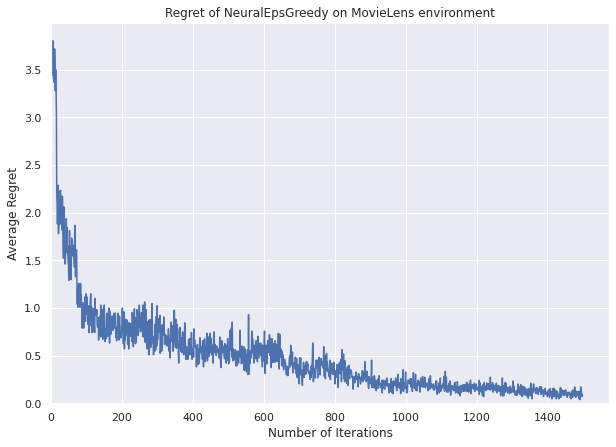

In [18]:
plot_regret(metrics['regret'], {'algorithm': 'NeuralEpsGreedy'})